#**Проект по дисциплине Инфраструктура Больших данных**

##**Цель проекта**

**Тема проекта: Реализация GPT-2 и обучение языковой модели на углубленной задаче.**

Задачи: Реализация языковых моделей GPT2 и GPT3, исследование их возможностей, обучение GPT2 на корпусе текстов на ненецком языке и оценка обученной модели.

##**Сбор данных для обучения языковой модели GPT-2**

Для составления корпуса использовались следующие источники:

*   [сообщество](https://vk.com/nn.yanao) общественно-политической национальной газеты Ямало-Ненецкого автономного округа "Няръяна Нгэрм" и [сообщество](https://vk.com/club173849556) газеты для носителей лесного диалекта ненецкого языка в социальной сети ВКонтакте;
*   [страница](http://www.yamalexpedition.ru/nen/blog-nen) дневниковых записей и [страница](http://www.yamalexpedition.ru/nen/education-for-nomads-nen) на тему кочевого образования на сайте этнографической экспедиции "Настоящие люди";
*   [сборник](https://libraries-yanao.ru/upload/iblock/289/Jangasova.pdf) ненецких сказок Янгасовой Н.М. 2007 года (Ненецие” лаханако”).

Программный код для сбора текста постов в социальной сети ВКонтакте на примере сообщества "Няръяна Нгэрм - старейшая газета Ямала"

```
import requests
import csv

access_token = 'API-key'
group_id = '147614552'
version = '5.131'

url = f'https://api.vk.com/method/wall.get?group_id=-{group_id}&access_token={access_token}&v={version}'

# отправление GET-запроса и получение JSON-объекта с данными
response = requests.get(url)
data = response.json()

if 'response' not in data:
    print(data['запрос не прошел успешно'])
else:
    # получение общего числа постов в группе
    count = data['response']['count']
    print(f'Количество постов: {count}')

    # получение всех постов на стене группы
    posts = []
    offset = 0
    while offset < count:
        url = f'https://api.vk.com/method/wall.get?group_id=-{group_id}&offset={offset}&count=100&access_token={access_token}&v={version}'
        response = requests.get(url)
        data = response.json()
        posts.extend(data['response']['items'])
        offset += 100

    print(f'Количество спарсенных постов: {len(posts)}')

    # сохранение данных в CSV-файл
    with open('nn_yanao_posts.csv', 'w', encoding='utf-8', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['link', 'text'])
        for post in posts:
            post_link = f'https://vk.com/wall-{group_id}_{post["id"]}'
            post_text = post.get('text', '')

            # преобразование текстовых элементов в строку между ссылками на посты
            text_lines = post_text.split('\n')
            combined_text = ''
            for line in text_lines:
                if not line.startswith('http'):
                    combined_text += line.strip() + ' '

            writer.writerow([post_link, combined_text.strip()])

    print('Данные о постах сохранены в nn_yanao_posts.csv')

```

Данный код формирует файл в формате csv с названием "nn_yanao_posts" с разметкой признаков 'link' и 'text' и записями, которые содержат текст преимущественно на ненецком языке в сообществе "Няръяна Нгэрм - старейшая газета Ямала". Записи могут не иметь текста (например, в том случае, если запись в социальной сети опубликована только с медиа-материалом, без текста) или иметь несколько абзацев в одной записи. Запись может содержать текст как полностью на ненецком языке, так и на русском.

Аналогичным способом с помощью VK API были собраны данные из другого сообщества газеты для носителей лесного диалекта ненецкого языка в файл nn_yanao_posts_2.csv.

Программный код для сбора текста в статьях сайта об этнографической экспедиции «Настоящие люди»

```
import requests
from bs4 import BeautifulSoup
import csv

url = "http://www.yamalexpedition.ru/nen/blog-nen/"

response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")

# нахождение всех элементов с классом "show-comment", содержащих ссылки на полные версии статей
links = soup.find_all("span", {"class": "show-comment"})

with open('articles_yamal_expedition.csv', 'w', encoding='utf-8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['link', 'title', 'text'])

    for link in links:
        # так как ссылки в html указаны без полного пути, ссылки модифицированы
        article_url = 'http://www.yamalexpedition.ru' + link.find("a")["href"]

        article_response = requests.get(article_url)
        article_soup = BeautifulSoup(article_response.text, "html.parser")

        article_title = article_soup.find('div', {'class': 'page-header'}).h1.text.strip()
        article_text = article_soup.find("div", {"itemprop": "articleBody"}).get_text(strip=True)

        writer.writerow([article_url, article_title, article_text])

```

Этот код формирует файл articles_yamal_expedition.csv с разметкой признаков 'link', 'title' и 'text' и записями, которые содержат текст полностью на ненецком языке со страницы дневниковых записей на сайте этнографической экспедиции "Настоящие люди". Записи имеют единый стиль оформления текста в сравнении с текстами из постов в социальной сети. Например, можно заметить, что в тексте знаком ʼ (звонкой тасерʼʼ) передается придыхание. Этот звук встречается в словах ненецкого языка чрезвычайно часто после гласных и согласных в конце и середине слова. Таким образом, данный гортанный смычный звук изменяет ряд слов по значению. Двумя знаками ʼʼ (глухой тасерʼʼ) обозначается более сильное придыхание. В отличии от данного текста, содержимое в постах социальной сети имеют различное написание данных знаков. Вместо символа ’ в тексте иногда стоит ᾿ или '. Вместо двух символов ’ изредка используют " или ”.

Так же были собраны текстовые данные со страницы на тему кочевого образования с этого же сайта в файл формата csv с названием "articles_yamal_expedition_2".

Для сбора данных из печатного сборника ненецких сказок (Ненецие” лаханако”) было применено распознавание и пост-редактирование ненецкого и русского текста в OCR-редакторе ABBYY FineReader PDF 15. Затем эти данные были скопированы в txt-файл, где были обработаны и преобразованы различные символы для единого стиля документа (такие как гортанный смычный звук, тире, цифры, которые обозначали в сборнике ссылки, и другие символы, которые могли распознаться некорректно).

Таким образом, в файле nenets_tales_yangasova.txt было определено 4 столбца: название сказки на ненецком языке (title_nen) и русском (title_rus), содержание сказки на ненецком (tale_nen) и русском (tale_rus).

## **Исследование и предварительная обработка данных**

Были применены следующие действия с собранными данными:

1.  Конкатенация различных наборов данных, выбор и формирование признака для решения задачи;
2.  Очистка данных от лишних символов: удаление переноса строк, хэштегов, текста в квадратных скобках (включительно);
3.  Удаление эмодзи;
4.  Удаление дубликатов и пустых записей;
5.  Удаление записей с количеством слов меньше 5.

In [ ]:
import pandas as pd
import numpy as np
import csv
import re

**Описание используемых наборов данных**

Для формирования корпуса было собрано 4 набора данных:

1.   nn_yanao_posts, 1915 записей, 2 признака: link и text принимают значения ссылки на пост и текстового содержания преимущественно на ненецком языке в постах сообщества "Няръяна Нгэрм - старейшая газета Ямала" в социальной сети ВКонтакте;
2.   nn_yanao_posts_2, 409 записей, 2 признака: link и text принимают аналогичные значения записей в сообществе газеты для носителей лесного диалекта ненецкого языка;
3.   articles_yamal_expedition, 37 записей, 3 признака: link, title и text определяющие ссылку на статью, ее заголовок и текст со страницы дневниковых записей на сайте этнографической экспедиции "Настоящие люди";
4.   articles_yamal_expedition_2, 5 записей, 3 признака: link, title и text обозначают идентичные данные со страницы на тему кочевого образования на сайте экспедиции;
5.   nenets_tales_yangasova.txt, 31 запись, 4 признака: title_nen, title_rus,	tale_nen и tale_rus, что соответственно содержит название сказок на ненецком языке и русском и их содержание на ненецком и русском.

In [ ]:
col_names_posts = ['link', 'text']
col_names_articles = ['link', 'title', 'text']

df1 = pd.read_csv('nn_yanao_posts.csv', names=col_names_posts, sep=',')
df1.drop(index=df1.index[0], axis=0, inplace=True)

df2 = pd.read_csv('nn_yanao_posts_2.csv', names=col_names_posts, sep=',')
df2.drop(index=df2.index[0], axis=0, inplace=True)

df3 = pd.read_csv('articles_yamal_expedition.csv', names=col_names_articles,
                  sep=',')
df3.drop(index=df3.index[0], axis=0, inplace=True)

df4 = pd.read_csv('articles_yamal_expedition_2.csv', names=col_names_articles,
                  sep=',')
df4.drop(index=df4.index[0], axis=0, inplace=True)

In [ ]:
df_posts = pd.concat([df1, df2], axis=0)
df_posts.style

In [ ]:
df_articles = pd.concat([df3, df4], axis=0)
df_articles.head(5)

link  \
1  http://www.yamalexpedition.ru/nen/blog-nen/pil...   
2  http://www.yamalexpedition.ru/nen/blog-nen/201...   
3  http://www.yamalexpedition.ru/nen/blog-nen/tyn...   
4  http://www.yamalexpedition.ru/nen/blog-nen/tay...   
5  http://www.yamalexpedition.ru/nen/blog-nen/nen...   

                                               title  \
1  Пилё᾽᾽, тудако᾽᾽, хавондир᾽᾽: таӈы серони᾽᾽ та...   
2  2015 по᾽неняӈг᾽᾽ иры: тамдая ӈэсовы мя, мор᾽᾽ ...   
3                                 Тынзям’ паӈгалпава   
4              Таӈы илма’’: неняӈг’’, «янямд’ хабця»   
5  Неняӈг᾽᾽ иры: мядонди᾽᾽, неняӈг᾽᾽, ӈавар᾽᾽ ня᾽...   

                                                text  
1  Неняӈг᾽᾽ иры᾽ 15 яляна 30 ӈэсына᾽᾽ ян᾽ палӈава...  
2  Сава някуцини᾽᾽, ӈани᾽ торовов! Тидари тари ӈа...  
3  Сянхавтаӈыманзаи’ня’’амнамалелаханакурӈаваць’’...  
4  Итя ӈабтеня’, Бованенково’ня’’амна ӈэдалёромах...  
5  Нерде няна толаӈгода няхана᾽᾽та᾽ ёльцеӈгана хо...

In [ ]:
df_articles['text'] = df_articles.apply(lambda row: row['title'] + '. ' +
                                        row['text'], axis=1)
df_articles = df_articles.drop('title', axis=1)
df_articles.style

In [ ]:
# удаление идентификаторов постов и удаление наименований статей с сайта для
# круговой диаграммы
df_posts['link'] = df_posts['link'].apply(lambda x: re.sub(r'(_\d+)', '', x))
df_articles['link'] = df_articles['link'].apply(lambda x:
                                                '/'.join(x.split('/')[:5]))
df_posts_articles = pd.concat([df_posts, df_articles], axis=0)

In [ ]:
df_posts_articles['text'].fillna('', inplace=True)

In [ ]:
def remove_special_characters(text):
    # удаление переноса строк
    text = re.sub(r'\n', ' ', text)
    # удаление хэштегов
    text = re.sub(r'#\S+', '', text)
    # удаление текста в квадратных скобках (включительно)
    text = re.sub(r'\[.*?\]', '', text)

    return text.strip()

df_posts_articles['text'] = df_posts_articles['text'].apply(remove_special_characters)

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002500-\U00002BEF"  # chinese char
                           u"\U00002702-\U000027B0"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           u"\u2640-\u2642"
                           u"\u2600-\u2B55"
                           u"\u200d"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\ufe0f"  # dingbats
                           u"\u3030"
                           "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', text)

df_posts_articles['text'] = df_posts_articles['text'].apply(remove_emoji)

In [ ]:
def nen_glottal_stop(text):
    # приведение всех символов, обозначающих гортанную смычку, к единому формату
    text = re.sub(r'(?<=[а-яёӓԓӈ])\'(?=\s)|(?<=[а-яёӓԓӈ])\'(?=[а-яёӓԓӈ])',
                  '’', text)
    text = re.sub(r'(?<=[а-яёӓԓӈ])\᾿(?=\s)|(?<=[а-яёӓԓӈ])\᾿(?=[а-яёӓԓӈ])',
                  '’', text)
    text = re.sub(r'(?<=[а-яёӓԓӈ])"(?=\s)|(?<=[а-яёӓԓӈ])"(?=[а-яёӓԓӈ])',
                  '”', text)
    text = re.sub(r'(?<=[а-яёӓԓӈ])\'\'(?=\s)|(?<=[а-яёӓԓӈ])\'\'(?=[а-яёӓԓӈ])',
                  '”', text)
    # удаление символов, которые не изменились с помощью выражений выше
    text = text.replace("'", "").replace("᾿", "").replace('"', "")

    return text.strip()

df_posts_articles['text'] = df_posts_articles['text'].apply(nen_glottal_stop)

In [ ]:
txt = 'nenets_tales_yangasova.txt'
csv_file = 'nenets_tales_yangasova.csv'
link_value = 'https://libraries-yanao.ru/upload/iblock/289/Jangasova.pdf'

with open(txt, 'r', encoding='utf-8') as f_txt, open(csv_file, 'w', encoding='utf-8', newline='') as f_csv:
    reader = f_txt.readlines()

    # cоздание объекта writer для записи в csv файл
    writer = csv.writer(f_csv, delimiter=',')
    writer.writerow(['link', 'title_nen', 'title_rus', 'tale_nen', 'tale_rus'])

    # определение и запись для каждой строки
    for i in range(0, len(reader), 4):
        title_nen = reader[i].strip()  # название сказки на ненецком языке
        tale_nen = reader[i+1].strip()  # текст сказки на ненецком языке
        title_rus = reader[i+2].strip()  # название сказки на русском языке
        tale_rus = reader[i+3].strip()  # текст сказки на русском языке
        writer.writerow([link_value, title_nen, title_rus, tale_nen, tale_rus])

In [ ]:
df_tales = pd.read_csv('nenets_tales_yangasova.csv', sep=',')
df_tales.drop(index=df_tales.index[0], axis=0, inplace=True)

In [ ]:
df_tales.head(5)

link             title_nen  \
1  https://libraries-yanao.ru/upload/iblock/289/J...             Хабей’ не   
2  https://libraries-yanao.ru/upload/iblock/289/J...  Вэсакохо’, пухуцяха’   
3  https://libraries-yanao.ru/upload/iblock/289/J...             Вано Сава   
4  https://libraries-yanao.ru/upload/iblock/289/J...      Маңгабада вэсако   
5  https://libraries-yanao.ru/upload/iblock/289/J...             Туңгэвыхы   

          title_rus                                           tale_nen  \
1     Женщина-ханты  Неро яхаконда хэвахана хабицяр илевы. сядэцяда...   
2  Старик и старуха  Я’ мидахана вэсакохо’, пухуцяха’ илевэхэ’. Нюд...   
3         Вано Сава  Параңода’ харад’ вэкана, няби вэта левсей хард...   
4     Бедный старик  Ңавнанда хунананда маңгабада вэсако танявы. Пы...   
5         Тунгэвыхы  Ся”ны ңэбта ңод” ңоб” не илевы. Няхар” хасава ...   

                                            tale_rus  
1  На берегу тальниковой речки жил маленький хант...  
2  Когда создавалась земля, жили старик и старуха...  
3  На окраине владений царя, в домике, вторая пол...  
4  Когда-то давно был бедный старик. Он бродил не...  
5  Однажды жила одна женщина. У нее было трое сын...

In [ ]:
df_tales['text'] = df_tales.apply(lambda row: row['title_nen'] + '. ' + row['tale_nen'], axis=1)

In [ ]:
df_tales = df_tales.drop(['title_nen', 'title_rus', 'tale_nen', 'tale_rus'], axis=1)
df_tales.style

In [ ]:
df = pd.concat([df_posts_articles, df_tales], axis=0)

In [ ]:
df['text'].drop_duplicates(inplace=True)
df['text'].replace('', np.nan, inplace=True)
df.dropna(subset=['text'], inplace=True)

In [ ]:
# удаление записей из набора данных, где количество слов меньше 5
df = df.loc[df['text'].apply(lambda x: len(x.split())) >= 5]

In [ ]:
df['text'].to_csv('corpus.csv', index=False)
df_link = df['link']
df.shape

(1734, 2)

In [ ]:
df = pd.read_csv('corpus.csv')
df.style

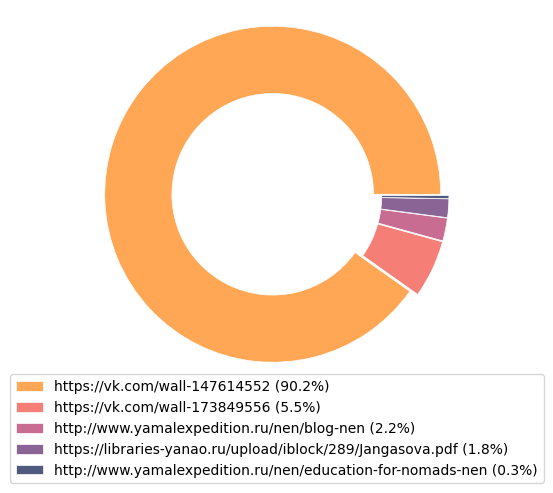

In [ ]:
import matplotlib.pyplot as plt

# подсчет количества ссылок в каждом источнике
counts = df_link.value_counts()

colors = ['#FFA755', '#F57F77', '#C96C91', '#8A6495', '#4F5A7E']
explode = [0.025] * len(counts)

# построение круговой диаграммы
plt.pie(counts.values, labels=None, colors=colors, explode=explode,
        wedgeprops={'linewidth': 0.5, 'edgecolor': 'white', 'width': 0.4})

# добавление легенды с процентным соотношением
legend_labels = [f'{label} ({count/sum(counts)*100:.1f}%)' for label, count in zip(counts.index, counts.values)]
plt.legend(legend_labels, loc="lower center", bbox_to_anchor=(0.5, -0.3))

# убираем надписи на самом графике
plt.gca().set_title('')

plt.axis('equal')
plt.show()

**Описание сформированного и предварительно обработанного корпуса**

Предварительно обработанный корпус текста имеет 1734 записи и 2 столбца: link (ссылка на источник) и text (пост в социальной сети, статья на сайте или сказка), где может содержаться предложение, абзац или несколько абзацев текста.

## **Реализация GPT-2 с библиотекой Transformers и платформой Hugging Face**


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import pipeline, GPT2LMHeadModel, GPT2Tokenizer

# загрузка предварительно обученной модели и токенизатора
model_name = 'gpt2'
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# настройка конвейера для генерации текста
chef = pipeline(
    'text-generation',
    model=model,
    tokenizer=tokenizer,
    config={'max_length': 800}
)

# использование конвейера для промптов
prompts = [
    'In a parallel universe',
    'Once upon a time, in a land full of magic',
]
for prompt in prompts:
    result = chef(prompt)
    print(result)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "In a parallel universe where space is the most important matter in the universe – the universe that we're seeing now – we would see our universe as populated with things like asteroids, ice-covered planets, starholes or star-studded worlds."}]
[{'generated_text': 'Once upon a time, in a land full of magic, we will have none. The world is too corrupt and too large to save us from it. There are no good things in our world for the dead. Even if we survive, there must'}]


## **Применение GPT-3 с OpenAI API**


In [ ]:
!pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import openai

openai.api_key = 'API-key'

completions = openai.Completion.create(
    engine="text-davinci-003",
    prompt="Did Alan Turing play a key role in World War II?",
    max_tokens=100,
    stop=None,
    temperature=0.1,
)

completions.choices[0].text

'\n\nYes, Alan Turing played a key role in World War II. He was a British mathematician and cryptanalyst who developed the Turing machine, a machine that could break the German Enigma code. This allowed the Allies to decipher German messages, which gave them a major advantage in the war.'

## **Тонкая настройка на сформированном корпусе текстов на ненецком языке**

Программный код для обучения языковой модели GPT-2 специфичным данным с помощью библиотеки transformers и платформы Hugging Face с оптимизатором AdamW

```
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments
from transformers.optimization import AdamW

# загрузка предобученной модели GPT-2
model_name = 'gpt2'
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# загрузка и подготовка данных
train_data_file = 'corpus.csv'
dataset = TextDataset(tokenizer=tokenizer, file_path=train_data_file, block_size=128)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# настройка параметров обучения
training_args = TrainingArguments(
    output_dir='./results',
    overwrite_output_dir=True,
    num_train_epochs=2,
    per_device_train_batch_size=8,
    save_steps=500,
    save_total_limit=2,
    prediction_loss_only=True,
    learning_rate=1e-5,
    weight_decay=0.01,
    adam_beta1=0.9,
    adam_beta2=0.98,
    adam_epsilon=1e-8,
)

# создание оптимизатора AdamW
optimizer = AdamW(model.parameters(), lr=training_args.learning_rate)

# создание Trainer и начало обучения
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
    optimizers=(optimizer, None)
)

trainer.train()

trainer.save_model('./trained_model')
```



Программный код для задания промпта и вывода сгенерированного текста обученной на специфичных данных языковой моделью GPT-2 с помощью библиотеки transformers и модуля torch

```
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

# загрузка дообученной модели
model_path = './results'
model = GPT2LMHeadModel.from_pretrained(model_path)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# промпт для генерации текста
prompt = 'prompt'

# кодирование промпта
input_ids = tokenizer.encode(prompt, return_tensors='pt')

# создание маски внимания
attention_mask = torch.ones(input_ids.shape, dtype=torch.long)

# генерация текста
output = model.generate(input_ids, attention_mask=attention_mask, max_length=100, pad_token_id=tokenizer.eos_token_id)

# декодирование сгенерированного текста
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

print(generated_text)
```



## **Оценка качества обученной языковой модели**

Здесь представлены сгенерированные текста предобученной модели GPT-2, которые уступают модели, обученной на корпусе, содержащем ненецкие текста.

In [ ]:
prompts = [
    'Ань торова',
    "Нани' торова!",
    'Лакамбой',
    'Серон сававна миңа”',
    'Мань манзаян’ миңам’'
]
for prompt in prompts:
    result = chef(prompt)
    print(result)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Ань торовая прольдее больемого призвиде монкорос'}]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Нани' торова!\n\n'восуппшетно перзграния прикь"}]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Лакамбой вепоря плоде наругова Россивая дексаи'}]


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Серон сававна миңа”оргиания\n\nСеророн сававна �'}]
[{'generated_text': 'Мань манзаян’ миңам’. набетовденнонномость к'}]


Специально обученная модель показывает значительно лучшие результаты в обработке ненецкого языка, чем предобученная модель без дополнительной настройки, так как она имеет еще более ограниченные знания о ненецком языке и его грамматике. Однако, для еще более качественных результатов, модель можно продолжать обучать на качественных и разнообразных данных, чтобы она становилась еще более совершенной в выполнении своей задачи.